In [ ]:
# Setup environment
!pip install torch torchvision
!pip install numpy nibabel matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

**Step 1: Data Loading & Preprocessing**

In [ ]:
# Dataset Loading & Preprocessing
import torch
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Replace 'path_to_your_ct_image.nii', 'path_to_your_cbct_image.nii', 'path_to_your_mask.nii' with actual paths
ct_img_path = 'ct.nii'
cbct_img_path = 'cbct.nii'
mask_path = 'mask.nii'

# Load the NIfTI files
ct_image = nib.load(ct_img_path).get_fdata()
cbct_image = nib.load(cbct_img_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

# Convert them to PyTorch tensors
ct_image = torch.tensor(ct_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
cbct_image = torch.tensor(cbct_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Define the new slicing indices to load a larger sub-volume
# Adjust the indices based on your data dimensions and memory constraints
start_slice = 80
end_slice = 140

# Load a larger sub-volume with adjusted slicing indices
ct_image_sub = ct_image[:, :, start_slice:end_slice, start_slice:end_slice, start_slice:end_slice]
cbct_image_sub = cbct_image[:, :, start_slice:end_slice, start_slice:end_slice, start_slice:end_slice]
mask_sub = mask[:, :, start_slice:end_slice, start_slice:end_slice, start_slice:end_slice]

# Check the shape of the loaded sub-volume
print("New CT Image sub-volume shape:", ct_image_sub.shape)
print("New CBCT Image sub-volume shape:", cbct_image_sub.shape)
print("New Mask sub-volume shape:", mask_sub.shape)


New CT Image sub-volume shape: torch.Size([1, 1, 60, 60, 60])
New CBCT Image sub-volume shape: torch.Size([1, 1, 60, 60, 60])
New Mask sub-volume shape: torch.Size([1, 1, 60, 60, 60])


**Step 2: Plotting of Image**

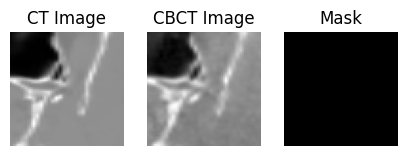

In [ ]:
# Convert the PyTorch tensors to NumPy arrays
ct_image_np = ct_image_sub.squeeze().numpy()
cbct_image_np = cbct_image_sub.squeeze().numpy()
mask_np = mask_sub.squeeze().numpy()

# Plot the CT image
plt.figure(figsize=(5, 5))
plt.subplot(1, 3, 1)
plt.imshow(ct_image_np[10, :, :], cmap='gray')
plt.title("CT Image")
plt.axis('off')

# Plot the CBCT image
plt.subplot(1, 3, 2)
plt.imshow(cbct_image_np[10, :, :], cmap='gray')
plt.title("CBCT Image")
plt.axis('off')

# Plot the mask image
plt.subplot(1, 3, 3)
plt.imshow(mask_np[10, :, :], cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.show()


**Step 3: Define Diffusion Model**

In [ ]:
# Define Diffusion Model
import torch.nn.functional as F

def forward_diffusion_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod[t]) # Preserved Original Image
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - alpha_cumprod[t]) #  Noise added to the image
    return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise

timesteps = 1000
beta = torch.linspace(0.0001, 0.02, timesteps)
alpha = 1.0 - beta
alpha_cumprod = torch.cumprod(alpha, axis=0)
alpha_cumprod_prev = torch.cat([torch.tensor([1.0]), alpha_cumprod[:-1]])


**Step 4: Define Conditional Denoising**

In [ ]:
#defining conditional Diffusion
import torch.nn as nn

class AdjustedConditionalDiffusionModel3D(nn.Module):
    def __init__(self, in_channels, cond_channels, out_channels):
        super(AdjustedConditionalDiffusionModel3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.conv2 = nn.Conv3d(64 + cond_channels, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        self.conv3 = nn.Conv3d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.conv4 = nn.Conv3d(128, out_channels, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(out_channels)

    def forward(self, x, cond, t):
        t_embedding = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand_as(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(torch.cat([x, cond], dim=1))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.bn4(self.conv4(x))
        return x

model = AdjustedConditionalDiffusionModel3D(in_channels=1, cond_channels=2, out_channels=1)




**Step 5: Training The model**

Epoch 1, Loss: 1.9970135688781738
Epoch 2, Loss: 1.9989631175994873
Epoch 3, Loss: 2.0026793479919434
Epoch 4, Loss: 1.9959555864334106
Epoch 5, Loss: 1.98812997341156
Epoch 6, Loss: 1.9946895837783813
Epoch 7, Loss: 2.0100560188293457
Epoch 8, Loss: 2.000844717025757
Epoch 9, Loss: 1.9933253526687622
Epoch 10, Loss: 2.0057575702667236
Epoch 11, Loss: 1.9913138151168823
Epoch 12, Loss: 1.9902771711349487
Epoch 13, Loss: 1.9972394704818726
Epoch 14, Loss: 1.9928261041641235
Epoch 15, Loss: 2.003953218460083
Epoch 16, Loss: 2.0002195835113525
Epoch 17, Loss: 1.9816200733184814
Epoch 18, Loss: 1.9886150360107422
Epoch 19, Loss: 1.983307123184204
Epoch 20, Loss: 1.9965780973434448


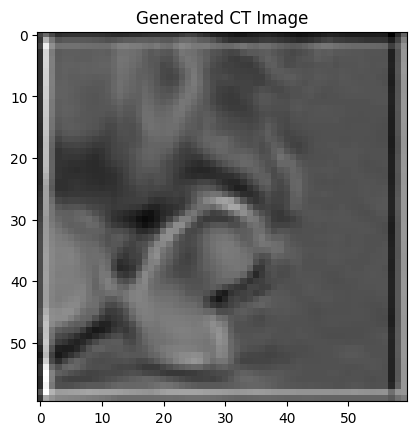

In [ ]:
#Training

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20

for epoch in range(num_epochs):
    t = torch.randint(0, timesteps, (1,), dtype=torch.long)
    noise = torch.randn_like(ct_image_sub)
    noisy_image = forward_diffusion_sample(ct_image_sub, t, noise)

    optimizer.zero_grad()
    output = model(noisy_image, torch.cat([cbct_image_sub, mask_sub], dim=1), t)
    loss = F.mse_loss(output, noise)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Visualize the output (middle slice of the sub-volume)
output_np = output.detach().squeeze().numpy()
plt.imshow(output_np[int(output_np.shape[0] / 2)], cmap='gray')
plt.title("Generated CT Image")
plt.show()





**Step 6: Generating Image**

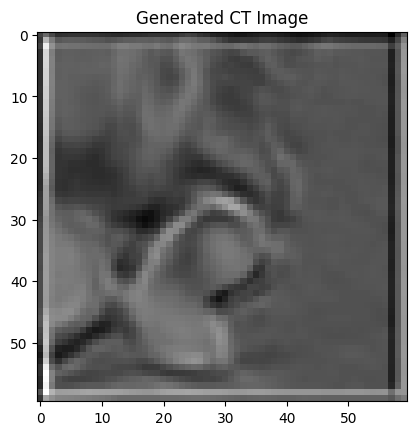

In [ ]:
# Here we just run a forward pass for testing
with torch.no_grad():
    t = torch.randint(0, timesteps, (1,), dtype=torch.long)
    noise = torch.randn_like(ct_image_sub)
    noisy_image = forward_diffusion_sample(ct_image_sub, t, noise)
    # Pass the noisy image, CBCT image, and mask as conditions
    output = model(noisy_image, torch.cat([cbct_image_sub, mask_sub], dim=1), t)

# Visualize the output (middle slice of the sub-volume)
output_np = output.detach().squeeze().numpy()
plt.imshow(output_np[int(output_np.shape[0] / 2)], cmap='gray')
plt.title("Generated CT Image")
plt.show()




**Step 7: Define Parameters**

In [ ]:
def calculate_mae(pred, target):
    return torch.mean(torch.abs(pred - target)).item()

def calculate_psnr(pred, target):
    mse = torch.mean((pred - target) ** 2).item()
    if mse == 0:
        return float('inf')
    max_pixel = torch.max(target).item()
    return 20 * math.log10(max_pixel / math.sqrt(mse))

def calculate_ncc(pred, target):
    pred_mean = torch.mean(pred)
    target_mean = torch.mean(target)
    numerator = torch.sum((pred - pred_mean) * (target - target_mean))
    denominator = torch.sqrt(torch.sum((pred - pred_mean) ** 2) * torch.sum((target - target_mean) ** 2))
    return (numerator / denominator).item()

**Step 8: Evaluation of Metrices**

MAE: 224.6051788330078
PSNR: 10.970287160303325
NCC: -0.4752572476863861


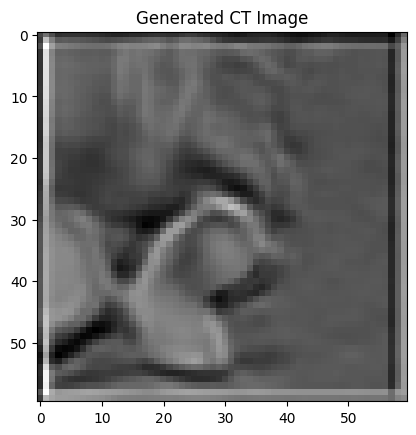

In [ ]:
# Switch to evaluation mode
model.eval()

# Run a forward pass for testing
with torch.no_grad():
    t = torch.randint(0, timesteps, (1,), dtype=torch.long)
    noise = torch.randn_like(ct_image_sub)
    noisy_image = forward_diffusion_sample(ct_image_sub, t, noise)
    output = model(noisy_image, torch.cat([cbct_image_sub, mask_sub], dim=1), t)

# Calculate evaluation metrics
mae = calculate_mae(output, ct_image_sub)
psnr = calculate_psnr(output, ct_image_sub)
ncc = calculate_ncc(output, ct_image_sub)

print(f"MAE: {mae}")
print(f"PSNR: {psnr}")
print(f"NCC: {ncc}")

# Visualize the output (middle slice of the sub-volume)
output_np = output.detach().squeeze().numpy()
plt.imshow(output_np[int(output_np.shape[0] / 2)], cmap='gray')
plt.title("Generated CT Image")
plt.show()
